# Lab 8c: Hidden Markov Model of Investor Sentiment
Hidden Markov models (HMMs) are Markov models with unobservable states $s\in\mathcal{S}$ but observable outcomes $o\in\mathcal{O}$. Each hidden state in an HMM emits an observable single $o_{t}$ at time $t$, with the emission probability:

$$
\begin{equation*}
P(Y = o_{t}\,|\,X = s_{t})
\end{equation*}
$$

where $Y$ is the observable outcome and $X$ is the hidden state. Similar to the transition probability, the emission probability must sum to unity:

$$
\begin{equation*}
\sum_{o\in\mathcal{O}} P(Y = o\,|\,X = s) = 1\qquad\forall{s\in\mathcal{S}}
\end{equation*}
$$

The emission probability plays a crucial role in HMMs, as it is used to calculate the likelihood of a sequence of observed symbols, 
given the current state of the hidden Markov chain. 

### Sentiment HMM
To explore these ideas, let's construct a three-state, three-output Hidden Markov Model (HMM):

<div>
    <center>
        <img src="figs/Fig-ThreeState-ThreeAction-Markov.png" width="480"/>
    </center>
</div>

that models an investor’s sentiment and reaction to a news feed. Let the states $\mathcal{S} = \left\{1,2,3\right\}$ correspond to `{optimistic, neutral, pessimistic}`. Each state $s_{j}$ in the HMM emits a unique action $a_{j}$, where $a_{1}$ corresponds to a `buy` action, $a_{2}$ corresponds to a `null` action, i.e., do nothing and $a_{3}$ corresponds to a `sell` action. The probability that the state transitions between state $s_{i}$ and $s_{j}$ in the next step is described by $p_{ij}$. In this model, we'll assume the transition from state $s_{2}\rightarrow{s_{1}}$ and $s_{2}\rightarrow{s_{3}}$ is governed by a function of the positive news fraction $\theta$:

$$
p(\theta,K,n) = \frac{\theta^{n}}{K^{n}+\theta^{n}}
$$

where $K$ and $n$ are person-specific parameters. In particular, let:

$$
\begin{eqnarray}
p_{21} & = & p(\theta,K,n) \\
p_{23} & = & 1 - p(\theta,K,n) \\
\end{eqnarray}
$$

The values for $p_{12}$ and $p_{32}$ will be independently specified and are assumed to be independent of the news stream.

### Objective and tasks
The objective of `Lab 8c` is to familiarize students with constructing and sampling Hidden Markov Models (HMMs). In this lab, we will:

* Task 1: Setup the Transition matrix $\mathbf{P}$, and compute the stationary distribution $\pi$
    - `TODO`: Select parameters for the $p(\theta,K,n)$ function, construct the Transition matrix $\mathbf{P}$ and compute $\pi$.
* Task 2: Setup the Emission Probability Matrix (EPM) for the sentiment HMM
    - `TODO`: Specify `EPM`, and construct a dictionary of categorical distributions that represent the output signal generated from state $s_{j}$
* Task 3: Simulate the Hidden Markov Model (HMM)
    - `TODO`: Sample the HMM and compute the action vector for a set of investors

## Setup
The computations in this lab (or example) are enabled by the [VLDecisionsPackage.jl](https://github.com/varnerlab/VLDecisionsPackage.jl.git) and several external `Julia` packages. To load the required packages and any custom codes the teaching team has developed to work with these packages, we [include](https://docs.julialang.org/en/v1/manual/code-loading/) the `Include.jl` file):

In [1]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-5760-Labs-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5760-Labs-F23/Manifest.toml`
    Updating git-repo `https://github.com/varnerlab/VLDecisionsPackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-5760-Labs-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5760-Labs-F23/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-5760-Labs-F23`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLDecisionsPackage.jl.git`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Installed URIs ─ v1.5.1
  No Changes to `~/Desktop/julia_work/CHEME-5760-Labs-F23/Project.toml`
    Updating `~/Desktop/julia_work/CHEME-5760-Labs-F23/Manifest.toml`
  [5c2747f8]

In [2]:
function iterate(P::Array{Float64,2}, counter::Int; maxcount::Int = 100, ϵ::Float64 = 0.1)::Array{Float64,2}

    # base case -
    if (counter == maxcount)
        return P
    else
        # generate a new P -
        P_new = P^(counter+1)
        err = P_new - P;
        if (norm(err)<=ϵ)
            return P_new
        else
            # we have NOT hit the error target, or the max iterations
            iterate(P_new, (counter+1), maxcount=maxcount, ϵ = ϵ)
        end
    end
end;

### Setup constants

In [3]:
number_of_hidden_states = 3;
number_of_observable_states = 3;
number_of_samples = 1000;
number_of_investors = 10;
number_of_simulation_steps = 480;

## Task 1. Setup the Transition matrix $\mathbf{P}$, and compute the stationary distribution $\pi$
Let's set up the transition matrix for our sentiment calculation. In our model, we have a `3`-states so the Transition matrix $\mathbf{P}$ will be a `3` $\times$ `3` matrix whose entries $p_{ij}$ describe the probability that we will transition from state $i$ to state $j$ in the next step. The values for $p_{21}$ and $p_{23}$ are functions of the fraction of positive news. First, let's define the $p(\theta,K,n)$ function, and specify some values for the parameters $K$, $n$ and $\theta$:

In [33]:
p(θ,K,n) = (θ^n)/(K^n+θ^n);
K,n,θ = 0.25,1.5,0.60; # select your own values

Next, let's visualize the $p_{21}$ and $p_{23}$ functions for different values of the fraction of positive news $\theta$, and look at how the parameters $K$ and $n$ influence the shape of the curves:

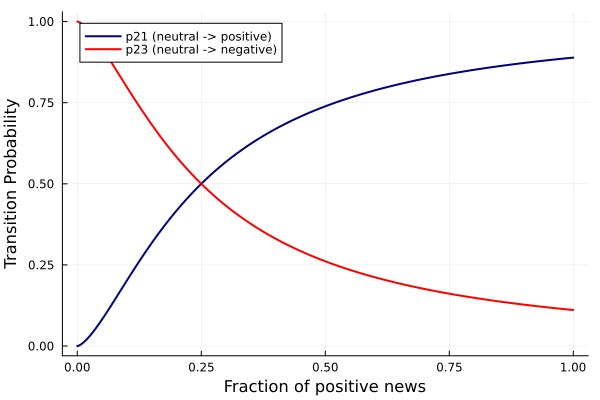

In [30]:
positive_news_fraction = range(0.0,1.0,length = number_of_samples) |> collect;
tmp_array = Array{Float64,2}(undef, number_of_samples, 3);
for i ∈ eachindex(positive_news_fraction)
    θ = positive_news_fraction[i];
    tmp_array[i,1] = θ
    tmp_array[i,2] = p(θ,K,n)
    tmp_array[i,3] = 1 - p(θ,K,n)
end
plot(tmp_array[:,1], tmp_array[:,2], lw=2, c=:navyblue, label="p21 (neutral -> positive)")
plot!(tmp_array[:,1], tmp_array[:,3], lw=2, c=:red, label="p23 (neutral -> negative)")
xlabel!("Fraction of positive news", fontsize=18)
ylabel!("Transition Probability", fontsize=18)

Then, specify the independent values in the transition probability matrix $\mathbf{P}$:

In [34]:
p21 = p(θ,K,n);
p23 = 1 - p(θ,K,n);
p12 = 0.4; # select your own values
p32 = 0.6; # select your own values

Finally, put all the entries together into the $\mathbf{P}$ matrix:

In [35]:
P = [
    1 - p12 p12 0.0        ; # state 1
    p21 1 - p23 - p21 p23  ; # state 2
    0.0 p32 1 - p32        ; # state 3
];

In [36]:
P

3×3 Matrix{Float64}:
 0.6       0.4  0.0
 0.788049  0.0  0.211951
 0.0       0.6  0.4

#### Stationary distribution $\pi$

We'll compute the stationary distribution $\pi$ using the recursive `iterate(...)` method. During each call to the `iterate(...)` method, we compute the matrix power of transition matrix $\mathbf{P}$. We continue to call the `iterate(...)` method until we hit one of two possible conditions:

* The `base case` for the recursion occurs when the `counter == maxcount`, at this point the recursion stops, and the matrix $\mathbf{P}$ is returned
* The recursion also stops when the difference between subsequent powers of the matrix $\mathbf{P}$ is smaller than a specified threshold

In [37]:
π̄ = iterate(P,1,ϵ = 0.000001)

3×3 Matrix{Float64}:
 0.592808  0.300899  0.106293
 0.592808  0.300899  0.106293
 0.592808  0.300899  0.106293

Let's create a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) using the stationary probability of our Markov chain using the [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) package, save this distribution in the variable `d`:

In [38]:
d = Categorical(π̄[1,:]);

## Task 2. Setup the Emission Probability Matrix (EPM)
In this model, each state emits a unique signal, thus the Emission Probability Matrix (EPM) will be the `3` $\times$ `3` identity matrix $\mathbf{I}$:

In [11]:
EPM = [
    1.0 0.0 0.0 ; # state 1
    0.0 1.0 0.0 ; # state 2
    0.0 0.0 1.0 ; # state 3
];

Populate the `emission_probability_dict`, which holds the [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) modeling the emission probability for each hidden state $s\in\mathcal{S}$, by building a categorical distribution for each state of the EPM:

In [39]:
emission_probability_dict = Dict{Int,Categorical}()
for i ∈ 1:number_of_hidden_states
    emission_probability_dict[i] = Categorical(EPM[i,:])
end

## Task 3: Simulate the Hidden Markov Model (HMM)
Finally, now that we have computed the stationary distribution, and the constructed the `emission_probability_dict`, we can sample our HMM model. First, we allocate storage to hold each investors simulation in the `investor_simulation::Array{Int,2}` array. Then, we simulate the behavior of `number_of_investors` using a `for` loop. For each iteration of the outer `for` loop:

* We simulate `number_of_simulation_steps` decisions by sampling the stationary distribution $\pi$, and then sampling the emission probability. 
* We stote the decision of investor `i` at step `j` in `investor_simulation[i,j]`

In [40]:
investor_simulation = Array{Int,2}(undef, number_of_investors, number_of_simulation_steps);
for i ∈ 1:number_of_investors
    for j ∈ 1:number_of_simulation_steps
    
        # which state is the mc in?
        hidden_state = rand(d);

        # grab the emission probability model from the emission_probability_dict -
        epd = emission_probability_dict[hidden_state];

        # role for a random ouput -
        investor_simulation[i,j] = rand(epd);
    end
end

In [41]:
investor_simulation

10×480 Matrix{Int64}:
 1  1  1  3  1  2  1  1  2  1  1  2  3  …  2  3  2  2  1  1  1  1  2  3  2  1
 1  1  1  1  2  1  2  3  2  1  1  1  2     1  1  2  1  1  1  3  1  1  3  2  2
 2  2  1  3  1  1  3  2  3  1  2  2  2     3  1  2  2  1  2  1  1  1  1  2  1
 2  1  3  1  2  2  1  1  2  2  3  3  1     1  2  2  2  1  2  1  1  2  3  2  1
 3  1  1  1  2  2  2  1  1  1  1  1  1     1  2  2  1  1  2  3  3  3  2  2  1
 2  1  1  1  2  2  2  1  2  1  1  1  3  …  1  3  2  1  1  1  1  1  1  1  2  1
 1  1  1  1  3  2  1  3  2  3  1  1  2     1  1  1  2  2  1  1  2  1  2  3  2
 1  1  1  1  1  3  1  1  1  3  1  3  2     1  1  2  1  2  2  1  1  2  1  1  1
 2  2  2  2  3  2  2  3  1  1  1  1  2     1  2  1  1  3  3  1  2  1  1  1  1
 2  1  1  1  1  2  2  2  3  3  1  2  1     2  1  3  2  1  1  3  1  1  1  3  2

In [46]:
test_value = 3;
investor_index = 10;
N₊ = 0;
for j ∈ 1:number_of_simulation_steps
    value = investor_simulation[investor_index,j];
      if (value == test_value)
        N₊ += 1
    end
end
probability = N₊/number_of_simulation_steps;
println("We observe $(test_value) with probability = $(probability)")

We observe 3 with probability = 0.10625
